# Calibrate Camera Response for the visible camera

In [2]:
import sys
sys.path.append('../')

In [3]:
import time
from tqdm import tqdm

import cv2
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
%matplotlib widget

from thorlabs_elliptec import ELLx
# from cameras.ids_ueye import uEye
# from cameras.lucid_swir import LucidSWIR
from cameras.wrapper_pyspin import Blackfly

from lights.light_intensity_controller import LightIntensityController

In [4]:
vis_cam_type = 'FLIR'        # 'IDS' or 'Lucid' or 'FLIR'
if vis_cam_type == 'IDS':
    vis_cam_obj = uEye()
    vis_cam_obj.set_exposure(200)
elif vis_cam_type == 'Lucid':
    vis_cam_obj = LucidSWIR()
    vis_cam_obj.printTemperatureInfo()
    vis_cam_obj.set_fps(10)
    vis_cam_obj.set_exposure(20000)
    vis_cam_obj.set_gain(0)
elif vis_cam_type == 'FLIR':
    vis_cam_obj = Blackfly()
    vis_cam_obj.set_fps(10)
    vis_cam_obj.set_gain(0)
    vis_cam_obj.set_exposure(100)
else:
    raise ValueError('Invalid visible camera type')

System Time: 1732731277.3269262 s...
Timestamp Latch Value: 10276339245000 ns...
Current FPS: 9.999772...
Exposure set to 3999.000000 us...
Gain set to 0.000000 dB...
Exposure set to 102.000000 us...


Exposure set to 10002.000000 us...
0.4691177983539095


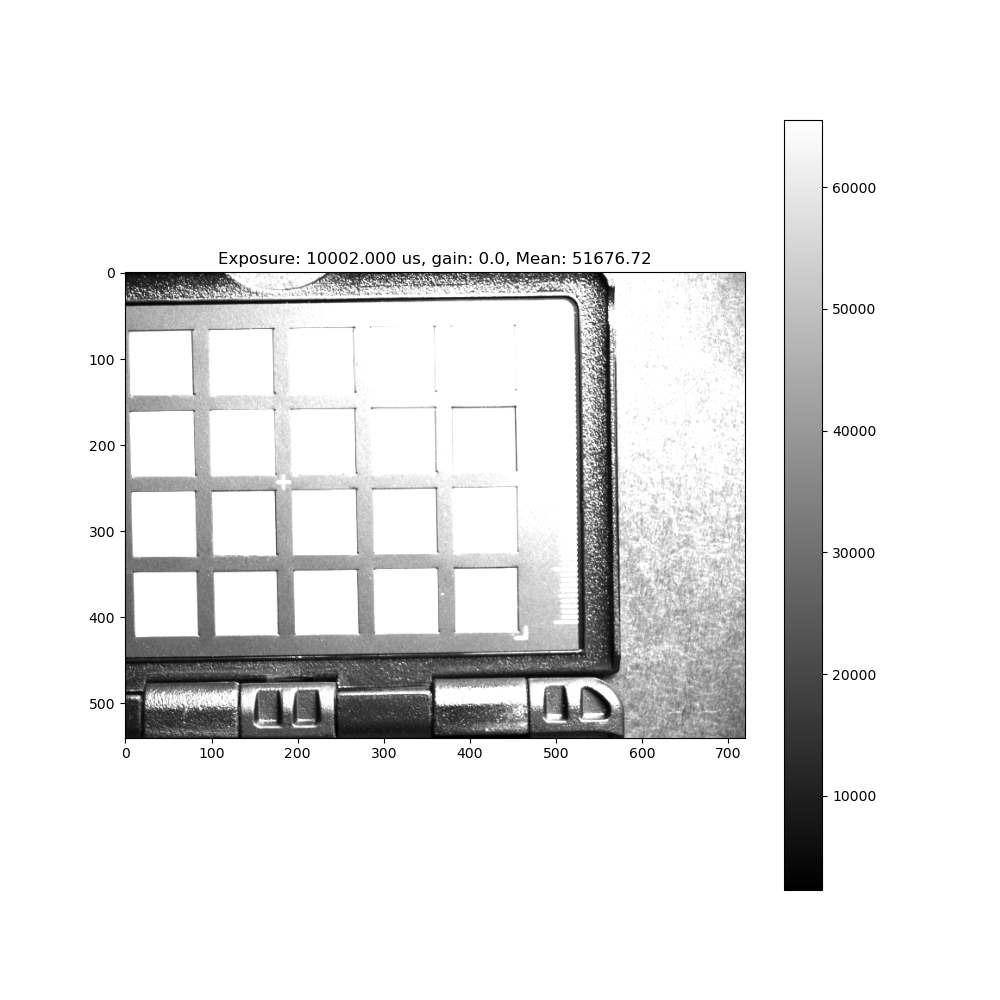

In [ ]:
vis_cam_obj.set_exposure(10000)
vis_img, vis_tstamp, exp_time, gain = vis_cam_obj.get_next_image(metadata=True)

print(np.where(vis_img > 65500)[0].shape[0] / vis_img.size)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(vis_img, cmap='gray')
ax.set_title(f'Exposure: {exp_time:.3f} us, gain: {gain}, Mean: {np.mean(vis_img):.2f}, Max: {np.max(vis_img)}')
plt.colorbar(im)
plt.show()


In [6]:
STAGE_POS_BP680 = 0
STAGE_POS_LP700 = 31
STAGE_POS_SP700 = 62
STAGE_POS_CLEAR = 93

In [9]:
curr_stage_pos = STAGE_POS_SP700
if 'stage' not in locals():
    stage = ELLx()
stage.move_absolute_raw(curr_stage_pos)

## Capture data for Camera Response Calibration

In [34]:
vis_cam_obj.set_fps(10)
vis_cam_obj.scan_exposures(10000)

Current FPS: 9.999772...
Exposure set to 10002.000000 us...
Exposure set to 11.000000 us...
Exposure set to 16.000000 us...
Exposure set to 21.000000 us...
Exposure set to 27.000000 us...
Exposure set to 32.000000 us...
Exposure set to 37.000000 us...
Exposure set to 43.000000 us...
Exposure set to 48.000000 us...
Exposure set to 53.000000 us...
Exposure set to 59.000000 us...
Exposure set to 64.000000 us...
Exposure set to 69.000000 us...
Exposure set to 75.000000 us...
Exposure set to 80.000000 us...
Exposure set to 86.000000 us...
Exposure set to 91.000000 us...
Exposure set to 96.000000 us...
Exposure set to 102.000000 us...
Exposure set to 107.000000 us...
Exposure set to 112.000000 us...
Exposure set to 118.000000 us...
Exposure set to 123.000000 us...
Exposure set to 128.000000 us...
Exposure set to 134.000000 us...
Exposure set to 139.000000 us...
Exposure set to 144.000000 us...
Exposure set to 150.000000 us...
Exposure set to 155.000000 us...
Exposure set to 160.000000 us...


[5.0,
 11.0,
 16.0,
 21.0,
 27.0,
 32.0,
 37.0,
 43.0,
 48.0,
 53.0,
 59.0,
 64.0,
 69.0,
 75.0,
 80.0,
 86.0,
 91.0,
 96.0,
 102.0,
 107.0,
 112.0,
 118.0,
 123.0,
 128.0,
 134.0,
 139.0,
 144.0,
 150.0,
 155.0,
 160.0,
 166.0,
 171.0,
 176.0,
 182.0,
 187.0,
 192.0,
 198.0,
 203.0,
 208.0,
 214.0,
 219.0,
 225.0,
 230.0,
 235.0,
 241.0,
 246.0,
 251.0,
 257.0,
 262.0,
 267.0,
 273.0,
 278.0,
 283.0,
 289.0,
 294.0,
 299.0,
 305.0,
 310.0,
 315.0,
 321.0,
 326.0,
 331.0,
 337.0,
 342.0,
 347.0,
 353.0,
 358.0,
 364.0,
 369.0,
 374.0,
 380.0,
 385.0,
 390.0,
 396.0,
 401.0,
 406.0,
 412.0,
 417.0,
 422.0,
 428.0,
 433.0,
 438.0,
 444.0,
 449.0,
 454.0,
 460.0,
 465.0,
 470.0,
 476.0,
 481.0,
 486.0,
 492.0,
 497.0,
 503.0,
 508.0,
 513.0,
 519.0,
 524.0,
 529.0,
 535.0,
 540.0,
 545.0,
 551.0,
 556.0,
 561.0,
 567.0,
 572.0,
 577.0,
 583.0,
 588.0,
 593.0,
 599.0,
 604.0,
 609.0,
 615.0,
 620.0,
 625.0,
 631.0,
 636.0,
 642.0,
 647.0,
 652.0,
 658.0,
 663.0,
 668.0,
 674.0,
 679.0,
 68

In [37]:
num_frames_vis = len(vis_cam_obj.exposure_vals)
print(f"Collecting {num_frames_vis} visible frames with exposure ranging from {vis_cam_obj.min_exp_val} to {vis_cam_obj.max_exp_val}...")
vis_frames = []
vis_tstamps = []
vis_exposures = []
pbar = tqdm(range(0, num_frames_vis, 10))
for i in pbar:
    exposure_val = vis_cam_obj.exposure_vals[i]
    actual_exposure_val = vis_cam_obj.set_exposure(exposure_val)
    pbar.set_description(f"Exposure: {actual_exposure_val:.3f}")
    frame, tstamp = vis_cam_obj.get_next_image()
    vis_frames.append(frame)
    vis_tstamps.append(tstamp)
    vis_exposures.append(actual_exposure_val)
vis_frames = np.stack(vis_frames, axis=-1)
vis_tstamps = np.array(vis_tstamps)
vis_exposures = np.array(vis_exposures)

output_filename = f'../data/visible_crf_filterPos{curr_stage_pos}_{num_frames_vis}_{time.time()}.npz'
np.savez(output_filename, vis_frames=vis_frames, vis_tstamps=vis_tstamps, vis_exposures=vis_exposures)

  0%|          | 0/188 [00:00<?, ?it/s]

Exposure: 5.000:   0%|          | 0/188 [00:00<?, ?it/s]

Exposure set to 5.000000 us...


Exposure: 59.000:   1%|          | 1/188 [00:00<00:41,  4.54it/s]

Exposure set to 59.000000 us...


Exposure: 112.000:   1%|          | 2/188 [00:00<00:49,  3.73it/s]

Exposure set to 112.000000 us...


Exposure: 166.000:   2%|▏         | 3/188 [00:01<00:52,  3.54it/s]

Exposure set to 166.000000 us...


Exposure: 219.000:   2%|▏         | 4/188 [00:01<00:53,  3.46it/s]

Exposure set to 219.000000 us...


Exposure: 273.000:   3%|▎         | 5/188 [00:01<00:53,  3.41it/s]

Exposure set to 273.000000 us...


Exposure: 273.000:   3%|▎         | 6/188 [00:01<00:53,  3.38it/s]

Exposure set to 326.000000 us...


Exposure: 326.000:   4%|▎         | 7/188 [00:02<00:53,  3.37it/s]

Exposure set to 380.000000 us...


Exposure: 433.000:   4%|▍         | 8/188 [00:02<00:53,  3.36it/s]

Exposure set to 433.000000 us...


Exposure: 486.000:   5%|▍         | 9/188 [00:02<00:53,  3.35it/s]

Exposure set to 486.000000 us...


Exposure: 486.000:   5%|▌         | 10/188 [00:02<00:53,  3.34it/s]

Exposure set to 540.000000 us...


Exposure: 593.000:   6%|▌         | 11/188 [00:03<00:52,  3.34it/s]

Exposure set to 593.000000 us...


Exposure: 593.000:   6%|▋         | 12/188 [00:03<00:52,  3.34it/s]

Exposure set to 647.000000 us...


Exposure: 700.000:   7%|▋         | 13/188 [00:04<00:52,  3.34it/s]

Exposure set to 700.000000 us...


Exposure: 700.000:   7%|▋         | 14/188 [00:04<00:52,  3.34it/s]

Exposure set to 754.000000 us...


Exposure: 807.000:   8%|▊         | 15/188 [00:04<00:51,  3.33it/s]

Exposure set to 807.000000 us...


Exposure: 807.000:   9%|▊         | 16/188 [00:04<00:51,  3.33it/s]

Exposure set to 861.000000 us...


Exposure: 914.000:   9%|▉         | 17/188 [00:05<00:51,  3.33it/s]

Exposure set to 914.000000 us...


Exposure: 968.000:  10%|▉         | 18/188 [00:05<00:50,  3.33it/s]

Exposure set to 968.000000 us...


Exposure: 1021.000:  10%|█         | 19/188 [00:05<00:50,  3.34it/s]

Exposure set to 1021.000000 us...


Exposure: 1021.000:  11%|█         | 20/188 [00:05<00:50,  3.34it/s]

Exposure set to 1075.000000 us...


Exposure: 1128.000:  11%|█         | 21/188 [00:06<00:50,  3.33it/s]

Exposure set to 1128.000000 us...


Exposure: 1128.000:  12%|█▏        | 22/188 [00:06<00:49,  3.33it/s]

Exposure set to 1181.000000 us...


Exposure: 1235.000:  12%|█▏        | 23/188 [00:07<00:49,  3.33it/s]

Exposure set to 1235.000000 us...


Exposure: 1288.000:  13%|█▎        | 24/188 [00:07<00:49,  3.33it/s]

Exposure set to 1288.000000 us...


Exposure: 1342.000:  13%|█▎        | 25/188 [00:07<00:48,  3.33it/s]

Exposure set to 1342.000000 us...


Exposure: 1395.000:  14%|█▍        | 26/188 [00:07<00:48,  3.33it/s]

Exposure set to 1395.000000 us...


Exposure: 1395.000:  14%|█▍        | 27/188 [00:08<00:48,  3.33it/s]

Exposure set to 1449.000000 us...


Exposure: 1502.000:  15%|█▍        | 28/188 [00:08<00:48,  3.33it/s]

Exposure set to 1502.000000 us...


Exposure: 1556.000:  15%|█▌        | 29/188 [00:08<00:47,  3.33it/s]

Exposure set to 1556.000000 us...


Exposure: 1609.000:  16%|█▌        | 30/188 [00:09<00:47,  3.33it/s]

Exposure set to 1609.000000 us...


Exposure: 1609.000:  16%|█▋        | 31/188 [00:09<00:47,  3.33it/s]

Exposure set to 1663.000000 us...


Exposure: 1716.000:  17%|█▋        | 32/188 [00:09<00:46,  3.33it/s]

Exposure set to 1716.000000 us...


Exposure: 1770.000:  18%|█▊        | 33/188 [00:10<00:46,  3.33it/s]

Exposure set to 1770.000000 us...


Exposure: 1823.000:  18%|█▊        | 34/188 [00:10<00:46,  3.33it/s]

Exposure set to 1823.000000 us...


Exposure: 1876.000:  19%|█▊        | 35/188 [00:10<00:45,  3.33it/s]

Exposure set to 1876.000000 us...


Exposure: 1930.000:  19%|█▉        | 36/188 [00:10<00:45,  3.33it/s]

Exposure set to 1930.000000 us...


Exposure: 1930.000:  20%|█▉        | 37/188 [00:11<00:45,  3.33it/s]

Exposure set to 1983.000000 us...


Exposure: 2037.000:  20%|██        | 38/188 [00:11<00:44,  3.33it/s]

Exposure set to 2037.000000 us...


Exposure: 2090.000:  21%|██        | 39/188 [00:11<00:44,  3.33it/s]

Exposure set to 2090.000000 us...


Exposure: 2144.000:  21%|██▏       | 40/188 [00:12<00:44,  3.33it/s]

Exposure set to 2144.000000 us...


Exposure: 2197.000:  22%|██▏       | 41/188 [00:12<00:44,  3.33it/s]

Exposure set to 2197.000000 us...


Exposure: 2197.000:  22%|██▏       | 42/188 [00:12<00:43,  3.33it/s]

Exposure set to 2251.000000 us...


Exposure: 2304.000:  23%|██▎       | 43/188 [00:13<00:43,  3.33it/s]

Exposure set to 2304.000000 us...


Exposure: 2358.000:  23%|██▎       | 44/188 [00:13<00:43,  3.33it/s]

Exposure set to 2358.000000 us...


Exposure: 2411.000:  24%|██▍       | 45/188 [00:13<00:42,  3.34it/s]

Exposure set to 2411.000000 us...


Exposure: 2465.000:  24%|██▍       | 46/188 [00:13<00:42,  3.33it/s]

Exposure set to 2465.000000 us...


Exposure: 2465.000:  25%|██▌       | 47/188 [00:14<00:42,  3.34it/s]

Exposure set to 2518.000000 us...


Exposure: 2571.000:  26%|██▌       | 48/188 [00:14<00:42,  3.33it/s]

Exposure set to 2571.000000 us...


Exposure: 2571.000:  26%|██▌       | 49/188 [00:14<00:41,  3.33it/s]

Exposure set to 2625.000000 us...


Exposure: 2678.000:  27%|██▋       | 50/188 [00:15<00:41,  3.33it/s]

Exposure set to 2678.000000 us...


Exposure: 2732.000:  27%|██▋       | 51/188 [00:15<00:41,  3.33it/s]

Exposure set to 2732.000000 us...


Exposure: 2732.000:  28%|██▊       | 52/188 [00:15<00:40,  3.34it/s]

Exposure set to 2785.000000 us...


Exposure: 2839.000:  28%|██▊       | 53/188 [00:16<00:40,  3.34it/s]

Exposure set to 2839.000000 us...


Exposure: 2892.000:  29%|██▊       | 54/188 [00:16<00:40,  3.33it/s]

Exposure set to 2892.000000 us...


Exposure: 2946.000:  29%|██▉       | 55/188 [00:16<00:39,  3.33it/s]

Exposure set to 2946.000000 us...


Exposure: 2946.000:  30%|██▉       | 56/188 [00:16<00:39,  3.33it/s]

Exposure set to 2999.000000 us...


Exposure: 2999.000:  30%|███       | 57/188 [00:17<00:39,  3.33it/s]

Exposure set to 3053.000000 us...


Exposure: 3106.000:  31%|███       | 58/188 [00:17<00:39,  3.33it/s]

Exposure set to 3106.000000 us...


Exposure: 3159.000:  31%|███▏      | 59/188 [00:17<00:38,  3.34it/s]

Exposure set to 3159.000000 us...


Exposure: 3213.000:  32%|███▏      | 60/188 [00:18<00:38,  3.33it/s]

Exposure set to 3213.000000 us...


Exposure: 3266.000:  32%|███▏      | 61/188 [00:18<00:38,  3.33it/s]

Exposure set to 3266.000000 us...


Exposure: 3266.000:  33%|███▎      | 62/188 [00:18<00:37,  3.33it/s]

Exposure set to 3320.000000 us...


Exposure: 3373.000:  34%|███▎      | 63/188 [00:19<00:37,  3.33it/s]

Exposure set to 3373.000000 us...


Exposure: 3427.000:  34%|███▍      | 64/188 [00:19<00:37,  3.33it/s]

Exposure set to 3427.000000 us...


Exposure: 3480.000:  35%|███▍      | 65/188 [00:19<00:36,  3.33it/s]

Exposure set to 3480.000000 us...


Exposure: 3480.000:  35%|███▌      | 66/188 [00:19<00:36,  3.33it/s]

Exposure set to 3534.000000 us...


Exposure: 3587.000:  36%|███▌      | 67/188 [00:20<00:36,  3.33it/s]

Exposure set to 3587.000000 us...


Exposure: 3641.000:  36%|███▌      | 68/188 [00:20<00:35,  3.33it/s]

Exposure set to 3641.000000 us...


Exposure: 3694.000:  37%|███▋      | 69/188 [00:20<00:35,  3.33it/s]

Exposure set to 3694.000000 us...


Exposure: 3748.000:  37%|███▋      | 70/188 [00:21<00:35,  3.33it/s]

Exposure set to 3748.000000 us...


Exposure: 3748.000:  38%|███▊      | 71/188 [00:21<00:35,  3.33it/s]

Exposure set to 3801.000000 us...


Exposure: 3854.000:  38%|███▊      | 72/188 [00:21<00:34,  3.33it/s]

Exposure set to 3854.000000 us...


Exposure: 3908.000:  39%|███▉      | 73/188 [00:22<00:34,  3.34it/s]

Exposure set to 3908.000000 us...


Exposure: 3961.000:  39%|███▉      | 74/188 [00:22<00:34,  3.34it/s]

Exposure set to 3961.000000 us...


Exposure: 4015.000:  40%|███▉      | 75/188 [00:22<00:33,  3.33it/s]

Exposure set to 4015.000000 us...


Exposure: 4015.000:  40%|████      | 76/188 [00:22<00:33,  3.33it/s]

Exposure set to 4068.000000 us...


Exposure: 4068.000:  41%|████      | 77/188 [00:23<00:33,  3.33it/s]

Exposure set to 4122.000000 us...


Exposure: 4175.000:  41%|████▏     | 78/188 [00:23<00:33,  3.33it/s]

Exposure set to 4175.000000 us...


Exposure: 4229.000:  42%|████▏     | 79/188 [00:23<00:32,  3.33it/s]

Exposure set to 4229.000000 us...


Exposure: 4229.000:  43%|████▎     | 80/188 [00:23<00:32,  3.33it/s]

Exposure set to 4282.000000 us...


Exposure: 4336.000:  43%|████▎     | 81/188 [00:24<00:32,  3.33it/s]

Exposure set to 4336.000000 us...


Exposure: 4336.000:  44%|████▎     | 82/188 [00:24<00:31,  3.33it/s]

Exposure set to 4389.000000 us...


Exposure: 4443.000:  44%|████▍     | 83/188 [00:25<00:31,  3.33it/s]

Exposure set to 4443.000000 us...


Exposure: 4496.000:  45%|████▍     | 84/188 [00:25<00:31,  3.33it/s]

Exposure set to 4496.000000 us...


Exposure: 4549.000:  45%|████▌     | 85/188 [00:25<00:30,  3.33it/s]

Exposure set to 4549.000000 us...


Exposure: 4549.000:  46%|████▌     | 86/188 [00:25<00:30,  3.33it/s]

Exposure set to 4603.000000 us...


Exposure: 4603.000:  46%|████▋     | 87/188 [00:26<00:30,  3.34it/s]

Exposure set to 4656.000000 us...


Exposure: 4710.000:  47%|████▋     | 88/188 [00:26<00:30,  3.33it/s]

Exposure set to 4710.000000 us...


Exposure: 4763.000:  47%|████▋     | 89/188 [00:26<00:29,  3.33it/s]

Exposure set to 4763.000000 us...


Exposure: 4817.000:  48%|████▊     | 90/188 [00:27<00:29,  3.34it/s]

Exposure set to 4817.000000 us...


Exposure: 4817.000:  48%|████▊     | 91/188 [00:27<00:29,  3.33it/s]

Exposure set to 4870.000000 us...


Exposure: 4924.000:  49%|████▉     | 92/188 [00:27<00:28,  3.33it/s]

Exposure set to 4924.000000 us...


Exposure: 4977.000:  49%|████▉     | 93/188 [00:28<00:28,  3.33it/s]

Exposure set to 4977.000000 us...


Exposure: 5031.000:  50%|█████     | 94/188 [00:28<00:28,  3.33it/s]

Exposure set to 5031.000000 us...


Exposure: 5084.000:  51%|█████     | 95/188 [00:28<00:27,  3.33it/s]

Exposure set to 5084.000000 us...


Exposure: 5084.000:  51%|█████     | 96/188 [00:28<00:27,  3.33it/s]

Exposure set to 5138.000000 us...


Exposure: 5138.000:  52%|█████▏    | 97/188 [00:29<00:27,  3.33it/s]

Exposure set to 5191.000000 us...


Exposure: 5244.000:  52%|█████▏    | 98/188 [00:29<00:27,  3.33it/s]

Exposure set to 5244.000000 us...


Exposure: 5298.000:  53%|█████▎    | 99/188 [00:29<00:26,  3.33it/s]

Exposure set to 5298.000000 us...


Exposure: 5298.000:  53%|█████▎    | 100/188 [00:29<00:26,  3.33it/s]

Exposure set to 5351.000000 us...


Exposure: 5351.000:  54%|█████▎    | 101/188 [00:30<00:26,  3.33it/s]

Exposure set to 5405.000000 us...


Exposure: 5458.000:  54%|█████▍    | 102/188 [00:30<00:25,  3.33it/s]

Exposure set to 5458.000000 us...


Exposure: 5512.000:  55%|█████▍    | 103/188 [00:31<00:25,  3.33it/s]

Exposure set to 5512.000000 us...


Exposure: 5565.000:  55%|█████▌    | 104/188 [00:31<00:25,  3.33it/s]

Exposure set to 5565.000000 us...


Exposure: 5565.000:  56%|█████▌    | 105/188 [00:31<00:24,  3.33it/s]

Exposure set to 5619.000000 us...


Exposure: 5672.000:  56%|█████▋    | 106/188 [00:31<00:24,  3.33it/s]

Exposure set to 5672.000000 us...


Exposure: 5672.000:  57%|█████▋    | 107/188 [00:32<00:24,  3.33it/s]

Exposure set to 5726.000000 us...


Exposure: 5779.000:  57%|█████▋    | 108/188 [00:32<00:24,  3.33it/s]

Exposure set to 5779.000000 us...


Exposure: 5779.000:  58%|█████▊    | 109/188 [00:32<00:23,  3.33it/s]

Exposure set to 5832.000000 us...


Exposure: 5886.000:  59%|█████▊    | 110/188 [00:33<00:23,  3.33it/s]

Exposure set to 5886.000000 us...


Exposure: 5939.000:  59%|█████▉    | 111/188 [00:33<00:23,  3.33it/s]

Exposure set to 5939.000000 us...


Exposure: 5939.000:  60%|█████▉    | 112/188 [00:33<00:22,  3.33it/s]

Exposure set to 5993.000000 us...


Exposure: 6046.000:  60%|██████    | 113/188 [00:34<00:22,  3.33it/s]

Exposure set to 6046.000000 us...


Exposure: 6100.000:  61%|██████    | 114/188 [00:34<00:22,  3.33it/s]

Exposure set to 6100.000000 us...


Exposure: 6153.000:  61%|██████    | 115/188 [00:34<00:21,  3.33it/s]

Exposure set to 6153.000000 us...


Exposure: 6153.000:  62%|██████▏   | 116/188 [00:34<00:21,  3.34it/s]

Exposure set to 6207.000000 us...


Exposure: 6207.000:  62%|██████▏   | 117/188 [00:35<00:21,  3.34it/s]

Exposure set to 6260.000000 us...


Exposure: 6314.000:  63%|██████▎   | 118/188 [00:35<00:20,  3.34it/s]

Exposure set to 6314.000000 us...


Exposure: 6367.000:  63%|██████▎   | 119/188 [00:35<00:20,  3.33it/s]

Exposure set to 6367.000000 us...


Exposure: 6421.000:  64%|██████▍   | 120/188 [00:36<00:20,  3.33it/s]

Exposure set to 6421.000000 us...


Exposure: 6474.000:  64%|██████▍   | 121/188 [00:36<00:20,  3.33it/s]

Exposure set to 6474.000000 us...


Exposure: 6474.000:  65%|██████▍   | 122/188 [00:36<00:19,  3.33it/s]

Exposure set to 6527.000000 us...


Exposure: 6527.000:  65%|██████▌   | 123/188 [00:36<00:19,  3.33it/s]

Exposure set to 6581.000000 us...


Exposure: 6634.000:  66%|██████▌   | 124/188 [00:37<00:19,  3.33it/s]

Exposure set to 6634.000000 us...


Exposure: 6688.000:  66%|██████▋   | 125/188 [00:37<00:18,  3.33it/s]

Exposure set to 6688.000000 us...


Exposure: 6688.000:  67%|██████▋   | 126/188 [00:37<00:18,  3.33it/s]

Exposure set to 6741.000000 us...


Exposure: 6795.000:  68%|██████▊   | 127/188 [00:38<00:18,  3.33it/s]

Exposure set to 6795.000000 us...


Exposure: 6848.000:  68%|██████▊   | 128/188 [00:38<00:17,  3.33it/s]

Exposure set to 6848.000000 us...


Exposure: 6902.000:  69%|██████▊   | 129/188 [00:38<00:17,  3.33it/s]

Exposure set to 6902.000000 us...


Exposure: 6902.000:  69%|██████▉   | 130/188 [00:38<00:17,  3.33it/s]

Exposure set to 6955.000000 us...


Exposure: 7009.000:  70%|██████▉   | 131/188 [00:39<00:17,  3.33it/s]

Exposure set to 7009.000000 us...


Exposure: 7062.000:  70%|███████   | 132/188 [00:39<00:16,  3.33it/s]

Exposure set to 7062.000000 us...


Exposure: 7116.000:  71%|███████   | 133/188 [00:40<00:16,  3.33it/s]

Exposure set to 7116.000000 us...


Exposure: 7169.000:  71%|███████▏  | 134/188 [00:40<00:16,  3.33it/s]

Exposure set to 7169.000000 us...


Exposure: 7222.000:  72%|███████▏  | 135/188 [00:40<00:15,  3.33it/s]

Exposure set to 7222.000000 us...


Exposure: 7276.000:  72%|███████▏  | 136/188 [00:40<00:15,  3.33it/s]

Exposure set to 7276.000000 us...


Exposure: 7276.000:  73%|███████▎  | 137/188 [00:41<00:15,  3.33it/s]

Exposure set to 7329.000000 us...


Exposure: 7383.000:  73%|███████▎  | 138/188 [00:41<00:15,  3.33it/s]

Exposure set to 7383.000000 us...


Exposure: 7436.000:  74%|███████▍  | 139/188 [00:41<00:14,  3.34it/s]

Exposure set to 7436.000000 us...


Exposure: 7490.000:  74%|███████▍  | 140/188 [00:42<00:14,  3.33it/s]

Exposure set to 7490.000000 us...


Exposure: 7490.000:  75%|███████▌  | 141/188 [00:42<00:14,  3.33it/s]

Exposure set to 7543.000000 us...


Exposure: 7597.000:  76%|███████▌  | 142/188 [00:42<00:13,  3.33it/s]

Exposure set to 7597.000000 us...


Exposure: 7650.000:  76%|███████▌  | 143/188 [00:43<00:13,  3.33it/s]

Exposure set to 7650.000000 us...


Exposure: 7704.000:  77%|███████▋  | 144/188 [00:43<00:13,  3.33it/s]

Exposure set to 7704.000000 us...


Exposure: 7704.000:  77%|███████▋  | 145/188 [00:43<00:12,  3.33it/s]

Exposure set to 7757.000000 us...


Exposure: 7757.000:  78%|███████▊  | 146/188 [00:43<00:12,  3.33it/s]

Exposure set to 7811.000000 us...


Exposure: 7864.000:  78%|███████▊  | 147/188 [00:44<00:12,  3.33it/s]

Exposure set to 7864.000000 us...


Exposure: 7917.000:  79%|███████▊  | 148/188 [00:44<00:11,  3.34it/s]

Exposure set to 7917.000000 us...


Exposure: 7971.000:  79%|███████▉  | 149/188 [00:44<00:11,  3.33it/s]

Exposure set to 7971.000000 us...


Exposure: 8024.000:  80%|███████▉  | 150/188 [00:45<00:11,  3.33it/s]

Exposure set to 8024.000000 us...


Exposure: 8024.000:  80%|████████  | 151/188 [00:45<00:11,  3.33it/s]

Exposure set to 8078.000000 us...


Exposure: 8078.000:  81%|████████  | 152/188 [00:45<00:10,  3.33it/s]

Exposure set to 8131.000000 us...


Exposure: 8185.000:  81%|████████▏ | 153/188 [00:46<00:10,  3.33it/s]

Exposure set to 8185.000000 us...


Exposure: 8238.000:  82%|████████▏ | 154/188 [00:46<00:10,  3.33it/s]

Exposure set to 8238.000000 us...


Exposure: 8238.000:  82%|████████▏ | 155/188 [00:46<00:09,  3.33it/s]

Exposure set to 8292.000000 us...


Exposure: 8292.000:  83%|████████▎ | 156/188 [00:46<00:09,  3.33it/s]

Exposure set to 8345.000000 us...


Exposure: 8399.000:  84%|████████▎ | 157/188 [00:47<00:09,  3.33it/s]

Exposure set to 8399.000000 us...


Exposure: 8452.000:  84%|████████▍ | 158/188 [00:47<00:08,  3.33it/s]

Exposure set to 8452.000000 us...


Exposure: 8505.000:  85%|████████▍ | 159/188 [00:47<00:08,  3.33it/s]

Exposure set to 8505.000000 us...


Exposure: 8505.000:  85%|████████▌ | 160/188 [00:47<00:08,  3.33it/s]

Exposure set to 8559.000000 us...


Exposure: 8559.000:  86%|████████▌ | 161/188 [00:48<00:08,  3.33it/s]

Exposure set to 8612.000000 us...


Exposure: 8666.000:  86%|████████▌ | 162/188 [00:48<00:07,  3.33it/s]

Exposure set to 8666.000000 us...


Exposure: 8719.000:  87%|████████▋ | 163/188 [00:49<00:07,  3.33it/s]

Exposure set to 8719.000000 us...


Exposure: 8719.000:  87%|████████▋ | 164/188 [00:49<00:07,  3.33it/s]

Exposure set to 8773.000000 us...


Exposure: 8826.000:  88%|████████▊ | 165/188 [00:49<00:06,  3.33it/s]

Exposure set to 8826.000000 us...


Exposure: 8826.000:  88%|████████▊ | 166/188 [00:49<00:06,  3.33it/s]

Exposure set to 8880.000000 us...


Exposure: 8880.000:  89%|████████▉ | 167/188 [00:50<00:06,  3.33it/s]

Exposure set to 8933.000000 us...


Exposure: 8987.000:  89%|████████▉ | 168/188 [00:50<00:06,  3.33it/s]

Exposure set to 8987.000000 us...


Exposure: 9040.000:  90%|████████▉ | 169/188 [00:50<00:05,  3.33it/s]

Exposure set to 9040.000000 us...


Exposure: 9094.000:  90%|█████████ | 170/188 [00:51<00:05,  3.33it/s]

Exposure set to 9094.000000 us...


Exposure: 9094.000:  91%|█████████ | 171/188 [00:51<00:05,  3.33it/s]

Exposure set to 9147.000000 us...


Exposure: 9200.000:  91%|█████████▏| 172/188 [00:51<00:04,  3.33it/s]

Exposure set to 9200.000000 us...


Exposure: 9254.000:  92%|█████████▏| 173/188 [00:52<00:04,  3.33it/s]

Exposure set to 9254.000000 us...


Exposure: 9307.000:  93%|█████████▎| 174/188 [00:52<00:04,  3.33it/s]

Exposure set to 9307.000000 us...


Exposure: 9307.000:  93%|█████████▎| 175/188 [00:52<00:03,  3.34it/s]

Exposure set to 9361.000000 us...


Exposure: 9414.000:  94%|█████████▎| 176/188 [00:52<00:03,  3.33it/s]

Exposure set to 9414.000000 us...


Exposure: 9468.000:  94%|█████████▍| 177/188 [00:53<00:03,  3.33it/s]

Exposure set to 9468.000000 us...


Exposure: 9521.000:  95%|█████████▍| 178/188 [00:53<00:03,  3.33it/s]

Exposure set to 9521.000000 us...


Exposure: 9575.000:  95%|█████████▌| 179/188 [00:53<00:02,  3.33it/s]

Exposure set to 9575.000000 us...


Exposure: 9628.000:  96%|█████████▌| 180/188 [00:54<00:02,  3.33it/s]

Exposure set to 9628.000000 us...


Exposure: 9628.000:  96%|█████████▋| 181/188 [00:54<00:02,  3.33it/s]

Exposure set to 9682.000000 us...


Exposure: 9735.000:  97%|█████████▋| 182/188 [00:54<00:01,  3.33it/s]

Exposure set to 9735.000000 us...


Exposure: 9789.000:  97%|█████████▋| 183/188 [00:55<00:01,  3.33it/s]

Exposure set to 9789.000000 us...


Exposure: 9789.000:  98%|█████████▊| 184/188 [00:55<00:01,  3.33it/s]

Exposure set to 9842.000000 us...


Exposure: 9842.000:  98%|█████████▊| 185/188 [00:55<00:00,  3.33it/s]

Exposure set to 9895.000000 us...


Exposure: 9949.000:  99%|█████████▉| 186/188 [00:55<00:00,  3.33it/s]

Exposure set to 9949.000000 us...


Exposure: 10002.000:  99%|█████████▉| 187/188 [00:56<00:00,  3.34it/s]

Exposure set to 10002.000000 us...


Exposure: 10002.000: 100%|██████████| 188/188 [00:56<00:00,  3.34it/s]


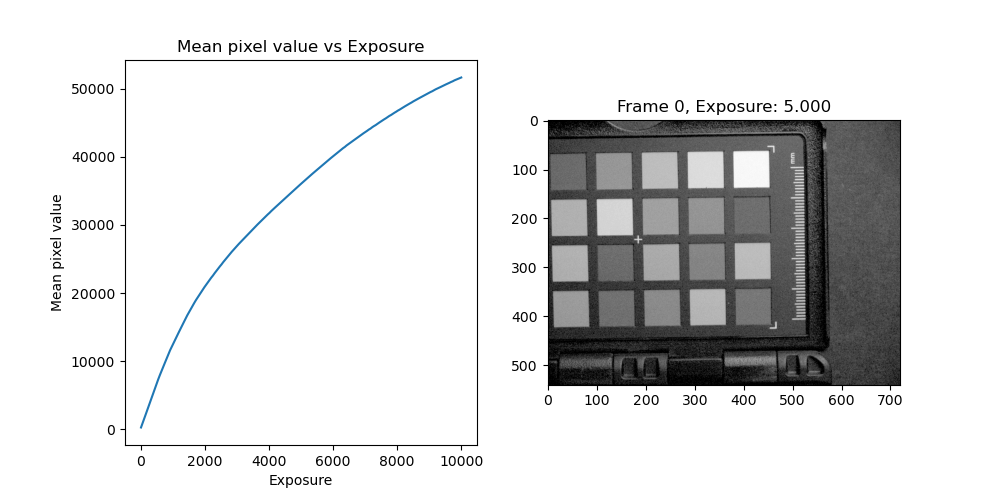

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(vis_exposures, vis_frames.mean(axis=(0, 1)))
ax[0].set_xlabel('Exposure')
ax[0].set_ylabel('Mean pixel value')
ax[0].set_title('Mean pixel value vs Exposure')
idx = np.random.randint(0, vis_frames.shape[-1])
idx = 0
ax[1].imshow(vis_frames[..., idx]**0.1, cmap='gray')
ax[1].set_title(f'Frame {idx}, Exposure: {vis_exposures[idx]:.3f}')
plt.show()

In [13]:
## IDS
vis_cam_obj.set_fps(10)
ad.set_dc_voltage(5.0)
time.sleep(0.5)

min_exposure_setting = 100
max_exposure_setting = 200

vis_cam_obj.set_exposure(min_exposure_setting)
min_exp_img_0 = vis_cam_obj.getNextImage()
ad.set_dc_voltage(2.5)
time.sleep(0.5)
# vis_cam_obj.set_exposure(max_exposure_setting)
max_exp_img_0 = vis_cam_obj.getNextImage()

Target frame rate: 10.0, actual frame rate: 9.999856627055609
Changed frame rate to 9.999856627055609 and camera now has exposure range: [0.0549, 99.82910000000001] ms
Exposure value 99.82910000000001 is greater than maximum 99.82910000000001
Exposure set to 99.82910000000001 ms


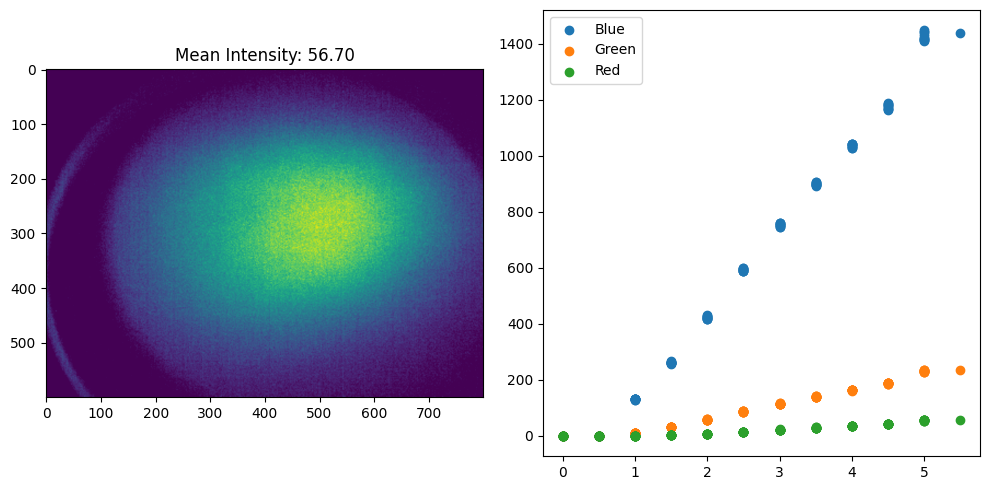

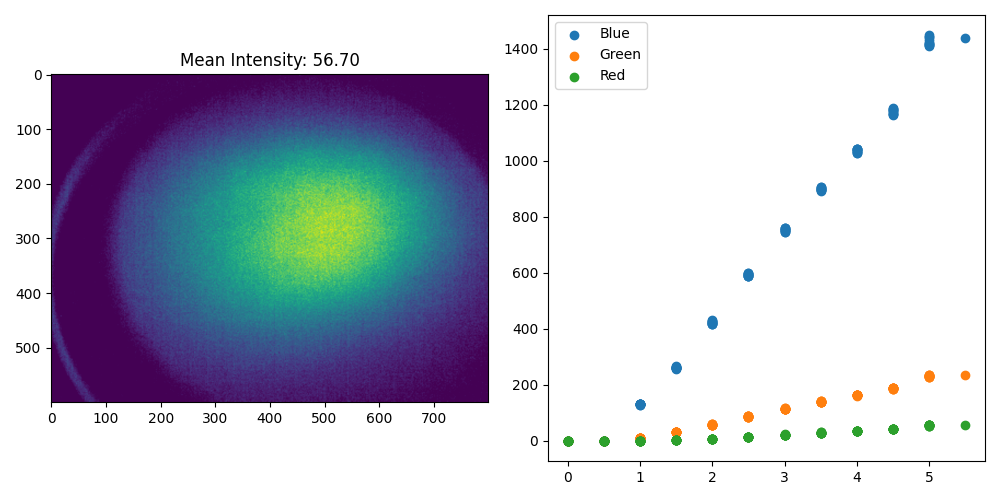

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vis_cam_obj.set_exposure(0.1)

mean_vals_b = []
mean_vals_g = []
mean_vals_r = []
voltage_vals = []
cnt = 1

curr_voltage = 0.0
ad.set_dc_voltage(curr_voltage)

while True:
    if cnt % 10 == 0:
        curr_voltage += 0.5
        ad.set_dc_voltage(np.minimum(curr_voltage, 5.0))
        time.sleep(0.5)
    vis_img = vis_cam_obj.getNextImage()

    vis_img_color = cv2.cvtColor(vis_img, cv2.COLOR_BAYER_RGGB2BGR)
    mean_vals_b.append(np.mean(vis_img_color[..., 0]))
    mean_vals_g.append(np.mean(vis_img_color[..., 1]))
    mean_vals_r.append(np.mean(vis_img_color[..., 2]))
    voltage_vals.append(curr_voltage)

    ax[0].clear()
    ax[1].clear()
    ax[0].imshow(vis_img_color[..., 2])
    ax[0].set_title(f'Mean Intensity: {np.mean(vis_img_color[..., 2]):.2f}')
    ax[1].scatter(voltage_vals, mean_vals_b, label='Blue')
    ax[1].scatter(voltage_vals, mean_vals_g, label='Green')
    ax[1].scatter(voltage_vals, mean_vals_r, label='Red')
    ax[1].legend()
    plt.tight_layout()
    display.clear_output(wait=True)
    display.display(plt.gcf())

    cnt += 1
    if curr_voltage > 5.0:
        break


In [9]:
from scipy.io import loadmat

crf_path = "../crf.mat"
intensity_to_irradiance = loadmat(crf_path)["crf"]


In [10]:
exposure_val = 0.05 * 1e-3
mean_intensity_vals_b = (np.array(mean_vals_b) / 16).astype(np.uint8)
mean_intensity_vals_g = (np.array(mean_vals_g) / 16).astype(np.uint8)
mean_intensity_vals_r = (np.array(mean_vals_r) / 16).astype(np.uint8)

mean_irradiance_vals_b = np.exp(intensity_to_irradiance[mean_intensity_vals_b, 0] - np.log(exposure_val))
mean_irradiance_vals_g = np.exp(intensity_to_irradiance[mean_intensity_vals_g, 1] - np.log(exposure_val))
mean_irradiance_vals_r = np.exp(intensity_to_irradiance[mean_intensity_vals_r, 2] - np.log(exposure_val))


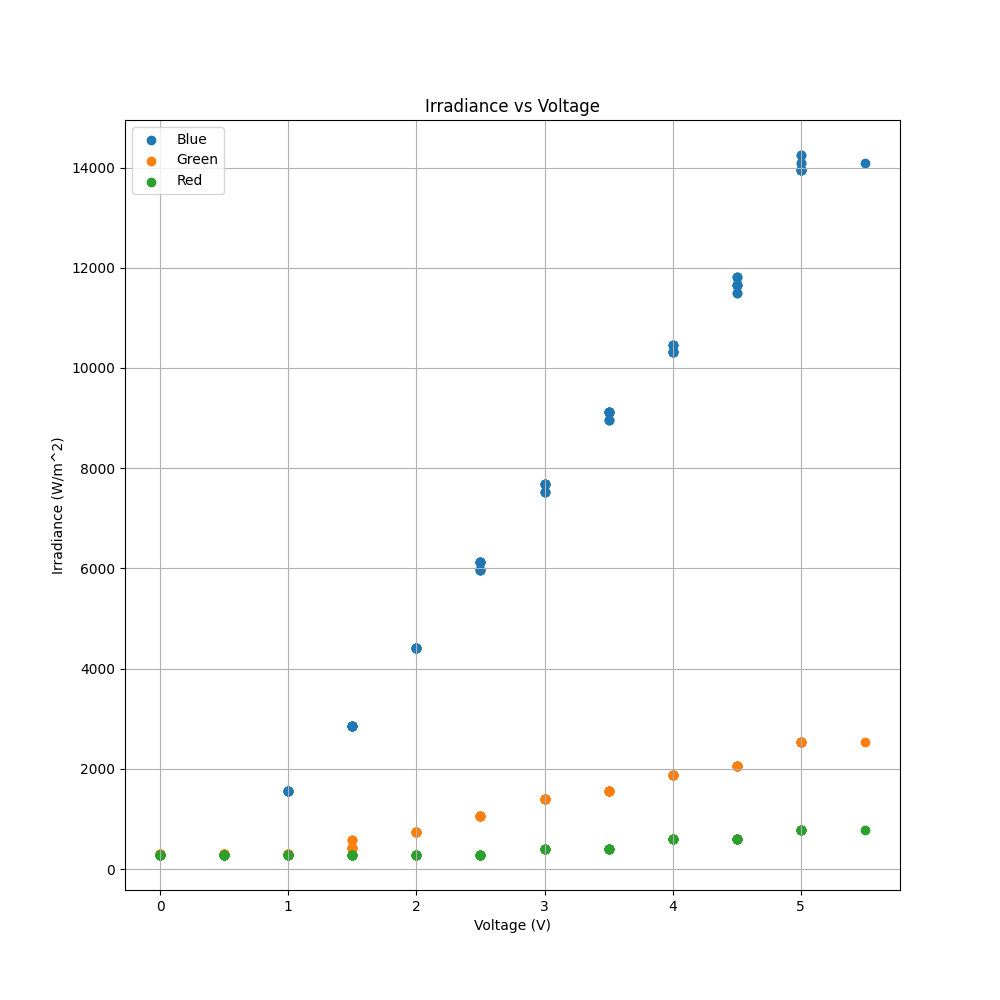

In [11]:
plt.figure(figsize=(10, 10))
plt.scatter(voltage_vals, mean_irradiance_vals_b, label='Blue')
plt.scatter(voltage_vals, mean_irradiance_vals_g, label='Green')
plt.scatter(voltage_vals, mean_irradiance_vals_r, label='Red')
plt.legend()
plt.xlabel('Voltage (V)')
plt.ylabel('Irradiance (W/m^2)')
plt.title('Irradiance vs Voltage')
plt.grid()
plt.show()

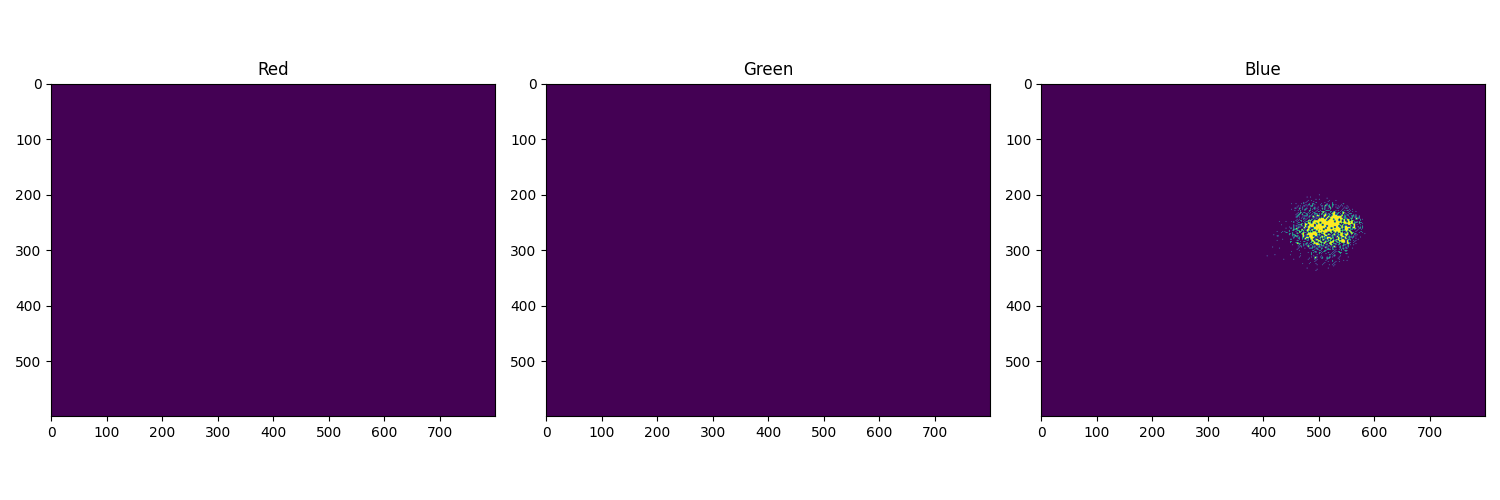

In [12]:
mask_r = vis_img_color[..., 2] >= 4090
mask_g = vis_img_color[..., 1] >= 4090
mask_b = vis_img_color[..., 0] >= 4090

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mask_r)
ax[0].set_title('Red')
ax[1].imshow(mask_g)
ax[1].set_title('Green')
ax[2].imshow(mask_b)
ax[2].set_title('Blue')
plt.tight_layout()
plt.show()

In [13]:
## LUCID
vis_cam_obj.set_fps(10)
ad.set_dc_voltage(0)

min_exposure_setting = 100
max_exposure_setting = 100000

vis_cam_obj.set_exposure(min_exposure_setting)
min_exp_img_0 = vis_cam_obj.getNextImage()
vis_cam_obj.set_exposure(max_exposure_setting)
max_exp_img_0 = vis_cam_obj.getNextImage()

Set acquisition frame rate to 10.0
Set exposure time to 99.576
Clipping requested exposure time to max value of 99811.616
Set exposure time to 99811.616


In [28]:
min_exp_img_0_color = np.uint8(cv2.cvtColor(min_exp_img_0, cv2.COLOR_BAYER_RGGB2RGB) // 16)
max_exp_img_0_color = np.uint8(cv2.cvtColor(max_exp_img_0, cv2.COLOR_BAYER_RGGB2RGB) // 16)

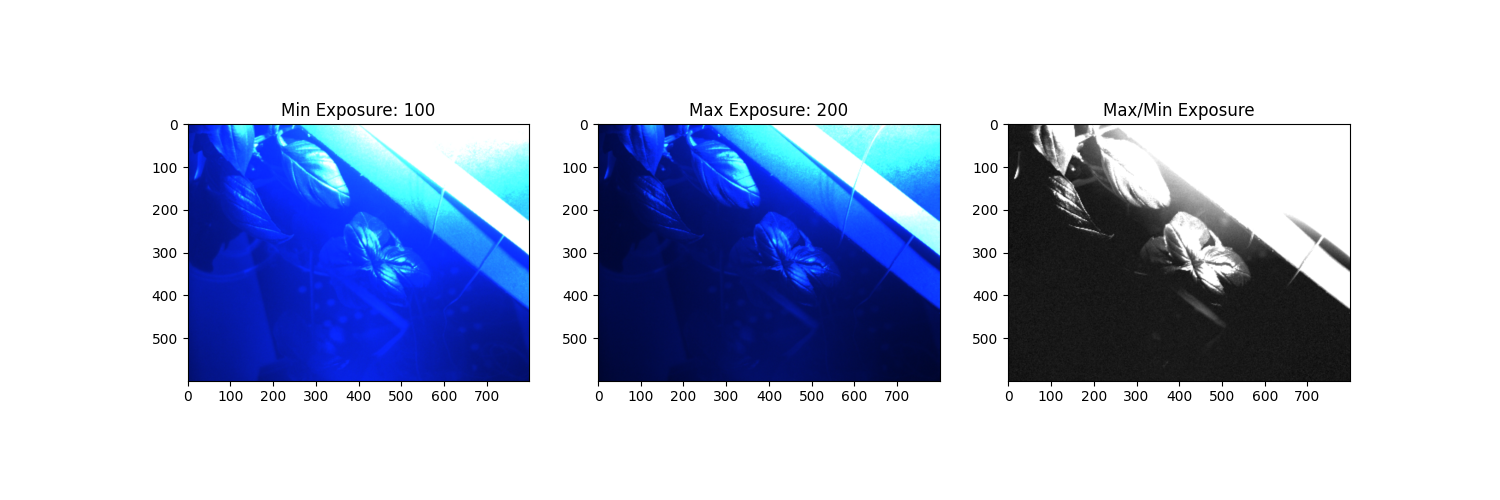

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(min_exp_img_0_color)
ax[0].set_title(f'Min Exposure: {min_exposure_setting}')
ax[1].imshow(max_exp_img_0_color)
ax[1].set_title(f'Max Exposure: {max_exposure_setting}')
ratio = max_exp_img_0_color[..., 2] / min_exp_img_0_color[..., 2]
ax[2].imshow(ratio, cmap='gray')
ax[2].set_title('Max/Min Exposure')
plt.show()

In [32]:
ratio[400:, :200].mean()

0.44150441191584167

In [ ]:
curr_stage_pos = STAGE_POS_SP700
stage.move_absolute_raw(curr_stage_pos, True)